# Analysis of german rental market by Maximilian Hilbert

# Collection of neccessary data

Get links of different german cities from wohnung.com/mietpreise

In [2]:
import requests
import re
import os
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from requests.exceptions import HTTPError

In [3]:
def get_links_mietpreise():
    url="https://www.wohnung.com/mietpreise"
    try:
        response = requests.get(url)
        # If the response was successful, no Exception will be raised
        response.raise_for_status()
    except HTTPError as http_err:
        print(f'HTTP error occurred: {http_err}')
    except Exception as err:
        print(f'Other error occurred: {err}')
    else:
        print('Successful connection')
    text=response.text
    link_list=re.findall("https://www.wohnung.com/[\w]+", text) #[^assets][^icon][^ratgeber][^vergleich]
    return link_list

In [4]:
links=get_links_mietpreise()

Successful connection


__downloading html-files of cities__

In [5]:
def download_html_files(link_lst):
    for i in tqdm(range(len(link_lst))):
        url=link_lst[i]
        try:
            response=requests.get(url)
            text=response.text
            filename=url.replace("https://www.wohnung.com/", "")
            with open("html_files_wohnung_com\\"+str(filename)+".html", "w", encoding="utf-8") as file:
                file.write(text)
                file.close()
                response.raise_for_status()
        except HTTPError as http_err:
            #print(f'HTTP error occurred: {http_err}')
            os.remove("html_files_wohnung_com\\"+filename+".html")
    return "Done."

In [6]:
download_html_files(links)

  0%|          | 0/5267 [00:00<?, ?it/s]


FileNotFoundError: [Errno 2] No such file or directory: 'html_files_wohnung_com\\assets.html'

In [ ]:
files=os.listdir("html_files_wohnung_com/")

__Cleaning of whitespaces__

In [ ]:
def cleaning_html():
    for i in tqdm(range(len(files))):
        filename=files[i]
        with open("html_files_wohnung_com\\"+filename, "r", encoding="utf-8") as file:
            text=file.read()
            file.close()
        new_text=re.sub("\s+", "", text)
        with open("html_files_wohnung_com\\"+filename, "w", encoding="utf-8") as file:
            file.write(new_text)
            file.close()
    return "Done."

In [ ]:
cleaning_html()

100%|██████████| 2469/2469 [00:04<00:00, 493.96it/s]


'Done.'

__Creating dictionary out of labels and data from the .html-files by searching for javascript tags via regex__

In [ ]:
def create_dict_labels():
    labels={}
    for i in tqdm(range(len(files))):
        filename=files[i]
        with open("html_files_wohnung_com\\"+str(filename), "r", encoding="utf-8") as file:
            text=file.read()
        try:
            raw=re.findall("id=\"rentprice\-development\-linechart\-chartjs\"[\S\s]*labels\:\[(.*?)\]", text)[0]
        except IndexError:
            pass
        try:
            if isinstance(raw, list):
                raw=raw[0].split(",")
            else:
                raw=raw.split(",")
            #changing pattern "Q1/2010" to "2010"
            cityname=re.findall("(.*)(?=.html)",filename)[0]
            labels[cityname]=[int(re.sub("\"", "", re.sub("\w+\d{1}\/", "", x))) for x in raw]
        except UnboundLocalError:
            pass
    return labels
create_dict_labels()

100%|██████████| 2469/2469 [00:00<00:00, 4997.36it/s]


{'aach': [2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017],
 'aachen': [2017, 2017, 2017, 2017],
 'aalen': [2017, 2017, 2017, 2017],
 'aarbergen': [2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017],
 'abensberg': [2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017],
 'absberg': [2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017],
 'abstatt': [2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017],
 'achim': [2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017],
 'achtrup': [2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017],
 'adelschlag': [2012, 2013, 2014, 2015, 2016, 2017],
 'adelsdorf': [2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017],
 'adenau': [2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017],
 'adendorf': [2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017],
 'adlkofen': [2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017],
 'aerzen': [2011, 2012, 2013, 2014, 2015, 2016, 2017],
 'affing': [2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017],
 'ahaus': [2010, 2011, 2012, 2013, 2014, 201

__Collecting Values out of .html files and correction of orders by filling with zeroes/nans____

u.U. parallelisieren

In [ ]:
def create_dict_data():
    values={}
    for i in tqdm(range(len(files))):
        filename=files[i]
        file=open("html_files_wohnung_com\\"+filename, "r", encoding="utf-8")
        text=file.read()
        try:
            raw=re.findall("(?=id\=\"rentprice\-development\-linechart\-chartjs)(.*?)(?<=\<\/script\>)", text)[0]
        except IndexError:
            pass
        try:
            data=re.findall("(?=data\:\[)([\S]*?)(?<=\,\])", raw)[0]
            data=re.findall("[0-9]+\.[0-9]+", data)
            #crop .html ending out of filename
            cityname=re.findall("(.*)(?=.html)",filename)[0]
            values[cityname]=[float(x) for x in data]
        except TypeError:
            pass
    return values

def changing_order(dict):
    for element in dict.values():
        while len(element)<16:
            element.insert(0, np.nan)
    return dict
    
dict_data=create_dict_data()
df_raw=pd.DataFrame.from_dict(changing_order(dict_data), orient="index")

100%|██████████| 2469/2469 [00:01<00:00, 2059.53it/s]


In [ ]:
df_raw.T["berlin"]

0       NaN
1       NaN
2       NaN
3       NaN
4       NaN
5       NaN
6       NaN
7      8.43
8      6.98
9      7.26
10     7.70
11     8.27
12     8.86
13     9.11
14     9.83
15    10.88
Name: berlin, dtype: float64

__Perform calculations on the dataset__

In [ ]:
def rename(dataframe):
    years=[x for x in range(2002, 2018)]
    dataframe[dataframe.columns]=dataframe[dataframe.columns].replace(0.0, np.nan)
    #df["amount of data"]=df.apply(lambda x: x.count()-1, axis=1)
    #df[df["amount of data"]==df["amount of data"].max()]
    dataframe=dataframe.rename({0: years[0], 1: years[1], 0: years[0], 1: years[1],2: years[2], 3: years[3],4: years[4], 5: years[5],
                6: years[6], 7: years[7],8: years[8], 9: years[9],0: years[0], 10: years[10],11: years[11], 12: years[12],
                13: years[13], 14: years[14],15: years[15]}, axis=1)
    return dataframe

In [ ]:
def calc(dataframe):
    dataframe=dataframe.T
    dataframe["Mean in € per m^2"]=dataframe.mean(skipna=True, axis=1)
    dataframe["Standarddeviation in € per m^2"]=dataframe.std(skipna=True, axis=1)
    dataframe["Number of historical datapoints"]=dataframe.count(axis=1)
    return dataframe

In [ ]:
df_calc=calc(rename(df_raw))

In [ ]:
df_calc

,Unnamed: 0,aach,aachen,aalen,aarbergen,abensberg,absberg,abstatt,achim,achtrup,...,zschorlau,zuelpich,zusmarshausen,zweibruecken,zwenkau,zwickau,zwingenberg,Mean in € per m^2,Standarddeviation in € per m^2,Number of historical datapoints
0,2002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.481667,0.739063,8
1,2003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.343333,0.782588,11
2,2004,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.791538,0.974315,15
3,2005,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.493077,0.768229,15
4,2006,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.516667,0.704847,17
5,2007,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.290625,0.850665,18
6,2008,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.10,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.390226,1.103880,135
7,2009,6.68,NaN,5.90,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,4.58,NaN,NaN,NaN,6.253333,1.458711,410
8,2010,5.14,6.95,6.10,5.20,4.53,4.72,7.11,5.64,5.45,...,4.11,5.27,5.55,4.88,5.02,4.80,7.62,5.964045,1.448575,2254
9,2011,5.68,7.19,6.15,5.46,6.05,4.51,6.56,5.89,4.99,...,5.17,5.35,5.72,4.93,4.97,4.84,7.50,6.060828,1.424802,2382


# Download and clean data from wohnung.com/alle-staedte in order to match city to state

In [ ]:
states=os.listdir("cities_by_state")

In [ ]:
def create_states_cities_dict():
    dict={}
    for state in states:
        with open("cities_by_state\\"+state+"\cities.txt","r", encoding="utf-8") as file:
            text=file.read()
            cities=re.findall("\n(\S+\s*\S*\s*\S*\s*\S*)(?=\d{1,2}\,)", text)
            #filter remaining digits
            cities=[re.sub("\d","",element) for element in cities]
            #convert all letters to lowercase and remove whitespaces and umlauts
            cities=[x.lower() for x in cities]
            cities=[re.sub(" ","",string) for string in cities]
            cities=[re.sub("Ü|ü","ue",string) for string in cities]
            cities=[re.sub("Ä|ä","ae",string) for string in cities]
            cities=[re.sub("Ö|ö","oe",string) for string in cities]
            cities=[re.sub("ß","ss",string) for string in cities]
            dict[state]=cities
    return dict

In [ ]:
dict_state_to_city=create_states_cities_dict()

In [ ]:
dict_state_to_city

{'Baden-Wuerttemberg': ['aalen',
  'abstatt',
  'achberg',
  'achstetten',
  'adelberg',
  'adelmannsfelden',
  'adelsheim',
  'affalterbach',
  'aglasterhausen',
  'aichelberg',
  'aichhalden',
  'aichstetten',
  'aichtal',
  'aichwald',
  'aidlingen',
  'aitern',
  'aitrach',
  'albbruck',
  'albershausen',
  'albstadt',
  'aldingen',
  'alfdorf',
  'allensbach',
  'alleshausen',
  'allmannsweiler',
  'alpirsbach',
  'altbach',
  'altensteig',
  'altheim',
  'althengstett',
  'althuette',
  'altlussheim',
  'altshausen',
  'ammerbuch',
  'amstetten',
  'amtzell',
  'angelbachtal',
  'appenweier',
  'argenbuehl',
  'asbach',
  'aspach',
  'asperg',
  'assamstadt',
  'asselfingen',
  'attenweiler',
  'auenwald',
  'auggen',
  'aulendorf',
  'backnang',
  'badbellingen',
  'badditzenbach',
  'badduerrheim',
  'badfriedrichshall',
  'badherrenalb',
  'badkrozingen',
  'badliebenzell',
  'badmergentheim',
  'badpeterstal-griesbach',
  'badrappenau',
  'badrippoldsau-schapbach',
  'badschu

In [ ]:
df_new=rename(df_raw)
df_new=df_new.reset_index()

In [ ]:
def match_cities_to_states(dataframe):
    lst=[]
    for city in dataframe["index"].values:
        for key in dict_state_to_city.keys():
            for element in dict_state_to_city[key]:
                if element==city:
                    idx=dataframe[dataframe["index"]==city].index
                    dataframe.loc[idx,"state"]=key
                else:
                    pass
    return dataframe

In [ ]:
df_new=match_cities_to_states(df_new)

In [ ]:
df_new.head()

,Unnamed: 0,index,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,state
0,0,aach,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.68,5.14,5.68,5.97,5.09,6.53,6.37,6.69,7.04,Rheinland-Pfalz
1,1,aachen,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.95,7.19,7.63,7.92,8.16,8.30,8.64,8.87,Nordrhein-Westfalen
2,2,aalen,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.90,6.10,6.15,6.39,6.73,7.12,7.62,8.38,8.66,Baden-Wuerttemberg
3,3,aarbergen,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.20,5.46,5.17,4.97,5.13,5.17,5.60,5.71,Hessen
4,4,abensberg,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.53,6.05,5.81,5.96,5.93,6.87,8.01,7.90,Bayern


__Groupby states and average the prices for different years__

In [ ]:
df_grouped=df_new.groupby("state").mean()

In [ ]:
df_grouped.head()

,state,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
0,Baden-Wuerttemberg,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.759643,6.612102,6.752458,6.846000,7.060615,7.221397,7.507043,7.969811,8.456354
1,Bayern,NaN,NaN,NaN,NaN,NaN,NaN,4.6,5.922059,6.340102,6.434101,6.655681,6.807259,7.004533,7.284161,7.755324,8.169422
2,Berlin,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.430000,6.980000,7.260000,7.700000,8.270000,8.860000,9.110000,9.830000,10.880000
3,Brandenburg,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.736667,6.031250,6.136829,6.513500,6.556829,6.520500,6.699268,7.252439
4,Bremen,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.490000,5.405000,5.650000,5.935000,6.120000,6.230000,6.285000,6.705000,7.135000


__Save DFs for usage in other file__

In [ ]:
df_grouped.to_csv("grouped.csv")
df_new.to_csv("not_crouped.csv")
df_calc.to_csv("calc_not_grouped.csv")

# HIER WEITER MACHEN

In [ ]:
df_grouped=pd.read_csv("grouped.csv")
df_new=pd.read_csv("not_crouped.csv")
df_calc=pd.read_csv("calc_not_grouped.csv")

__Calculation of Inflation has been performed externally__

1.0088375

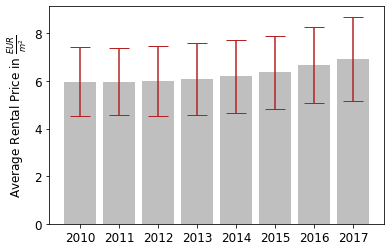

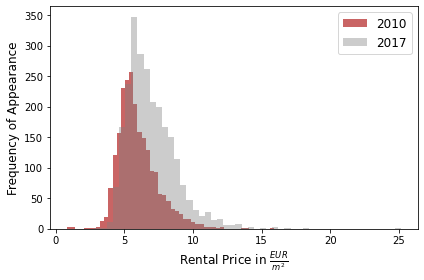

In [ ]:
def plots_whole_dataset():
    years=[x for x in range(2010, 2018)]

    errs=df_calc["Standarddeviation in € per m^2"]

    infl=[1.0077,1.0147,1.014,1.0098,1.007,1.0035,1.0035,1.0105]
    mean_infl_per_year=np.mean(infl)

    #############################################
    m_l=[5.964045293,5.973024274,6.000187398,6.080421653,6.185610177,6.352810253,6.661982701,6.922373201]
    std_l=[1.4485748,1.404161053,1.467860819,1.530786998,1.538005633,1.520089793,1.606702494,1.771854023]
    
    fig=plt.figure()
    fig.gca().bar(years, m_l, yerr=std_l, ecolor="firebrick",color="gray",align="center", alpha=0.5, capsize=10)
    fig.gca().set_ylabel("Average Rental Price in $\\frac{EUR}{m^2}$", fontsize=12)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)

    #plt.savefig("avg_rental_prices_barchart.pdf")

    fig2=plt.figure()

    fig2.gca().hist(df_new["2010"],alpha=0.7, color="firebrick", bins=50, label="2010")
    fig2.gca().hist(df_new["2017"].apply(lambda x: x/(mean_infl_per_year**7)), alpha=0.4, bins=50, label="2017", color="gray")
    plt.xlabel("Rental Price in $\\frac{EUR}{m^2}$", fontsize=12)
    plt.ylabel("Frequency of Appearance", fontsize=12)
    plt.legend(fontsize=12)
    plt.tight_layout()
    
    #plt.savefig("Paper/fig/Histogram_rental_prices.pdf")
    return np.mean(infl)
plots_whole_dataset()

In [ ]:
df_new["2017"]

NameError: name 'df_new' is not defined

In [ ]:
df_new.astype({"2010": 'float32',"2017": 'float32'}).dtypes

Unnamed: 0      int64
index          object
2002          float64
2003          float64
2004          float64
2005          float64
2006          float64
2007          float64
2008          float64
2009          float64
2010          float32
2011          float64
2012          float64
2013          float64
2014          float64
2015          float64
2016          float64
2017          float32
state          object
dtype: object

In [ ]:
df_sorted2010=df_new.sort_values(by=["2010"], ascending=False).head(10)
df_sorted2017=df_new.sort_values(by=["2017"], ascending=False).head(10)

In [ ]:
#bar_labels2010=df_sorted2010["index"].values.astype("str")
#bar_labels2017=df_sorted2017["index"].values.astype("str")

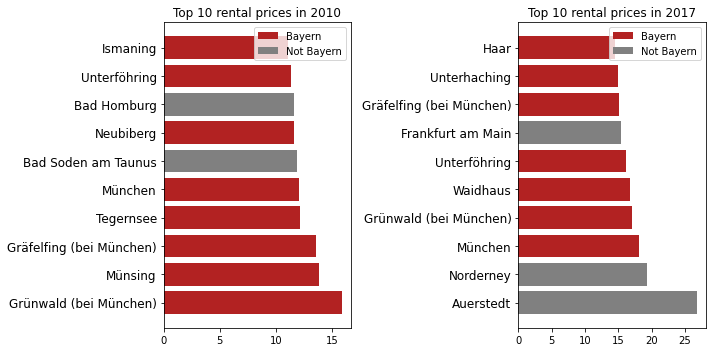

In [ ]:
def barchart_city_comparison():

    df_sorted2010=df_new.sort_values(by=["2010"], ascending=False).head(10)
    df_sorted2017=df_new.sort_values(by=["2017"], ascending=False).head(10)
    bar_labels_german_2010=["Grünwald (bei München)","Münsing", "Gräfelfing (bei München)","Tegernsee","München","Bad Soden am Taunus",
    "Neubiberg","Bad Homburg","Unterföhring","Ismaning"]
    bar_labels_german_2017=["Auerstedt","Norderney", "München","Grünwald (bei München)", "Waidhaus", "Unterföhring",
    "Frankfurt am Main","Gräfelfing (bei München)","Unterhaching","Haar"]
    y=np.arange(len(bar_labels_german_2010))
    fig,axs=plt.subplots(1,2,figsize=(10,5))

    mask11=df_sorted2010["state"]=="Bayern"
    mask12=df_sorted2010["state"]!="Bayern"

    mask21=df_sorted2017["state"]=="Bayern"
    mask22=df_sorted2017["state"]!="Bayern"

    x_1=df_sorted2010["2010"]
    axs[0].barh(y[mask11],x_1[mask11],label="Bayern", color="firebrick")
    axs[0].barh(y[mask12],x_1[mask12],label="Not Bayern", color="gray")
    axs[0].set_title("Top 10 rental prices in 2010", fontsize=12)
    axs[0].set_yticks(y)
    axs[0].set_yticklabels(labels=list(bar_labels_german_2010),fontsize=12)
    axs[0].legend()

    x_2=df_sorted2017["2017"]
    axs[1].barh(y[mask21],x_2[mask21],label="Bayern", color="firebrick")
    axs[1].barh(y[mask22],x_2[mask22],label="Not Bayern", color="gray")

    axs[1].set_title("Top 10 rental prices in 2017", fontsize=12)
    axs[1].set_yticks(y)
    axs[1].set_yticklabels(labels=list(bar_labels_german_2017),fontsize=12)
    axs[1].legend()

    plt.tight_layout()
    plt.savefig("barchart_city_comparison.pdf")
barchart_city_comparison()

__Farbcodes ändern+ labels anpassen__

In [ ]:
def label_func(array):
    print(array)

In [ ]:
df_grouped

,state,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
0,Baden-Wuerttemberg,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.759643,6.612102,6.752458,6.846000,7.060615,7.221397,7.507043,7.969811,8.456354
1,Bayern,NaN,NaN,NaN,NaN,NaN,NaN,4.600000,5.922059,6.340102,6.434101,6.655681,6.807259,7.004533,7.284161,7.755324,8.169422
2,Berlin,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.430000,6.980000,7.260000,7.700000,8.270000,8.860000,9.110000,9.830000,10.880000
3,Brandenburg,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.736667,6.031250,6.136829,6.513500,6.556829,6.520500,6.699268,7.252439
4,Bremen,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.490000,5.405000,5.650000,5.935000,6.120000,6.230000,6.285000,6.705000,7.135000
5,Hamburg,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.600000,9.910000,10.320000,10.560000,10.770000,10.770000,11.170000,11.870000
6,Hessen,NaN,NaN,NaN,NaN,NaN,NaN,4.660000,5.433750,6.073868,6.198645,6.368037,6.463178,6.631495,6.794554,7.041651,7.492465
7,Mecklenburg-Vorpommern,NaN,NaN,NaN,NaN,NaN,4.360000,7.140000,5.995000,5.522083,5.649750,5.686923,5.740750,5.714000,6.001500,6.222500,6.501250
8,Niedersachsen,5.481667,5.343333,5.791538,5.493077,5.516667,5.352667,5.500696,5.347500,5.338274,5.412466,5.510959,5.668919,5.846606,6.073333,6.375822,6.542978
9,Nordrhein-Westfalen,NaN,NaN,NaN,NaN,NaN,NaN,4.461429,5.584444,5.503555,5.574533,5.671419,5.737309,5.883667,5.984785,6.235567,6.520132


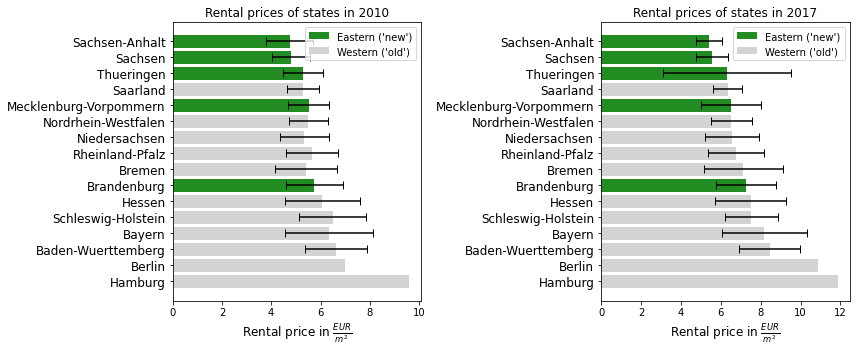

In [ ]:
def plot_rentals_states():
    
    #Sort by means for 2010 and calculate stds for states
    df_gr=df_grouped.drop(df_grouped.columns.difference(["state",'2010','2017']), axis=1)
    df_gr.sort_values(by=["2010"], ascending=False, inplace=True)
    df_std_2010=df_new.groupby("state").agg({"2010":np.std}).rename({"2010":"std_2010"},axis=1)
    
    #Sort by means for 2017 and calculate stds for states
    df_gr=df_grouped.drop(df_grouped.columns.difference(["state",'2010','2017']), axis=1)
    df_gr.sort_values(by=["2017"], ascending=False, inplace=True)
    df_std_2017=df_new.groupby("state").agg({"2017":np.std}).rename({"2017":"std_2017"},axis=1)
    
    #Merge to 2010/2017 dataframes
    df_grouped_2010=pd.merge(df_gr,df_std_2010, on="state", how="inner")
    df_grouped_2017=pd.merge(df_gr,df_std_2017, on="state", how="inner")
    
    eastern_lst = ["Brandenburg",
                   "Mecklenburg-Vorpommern",
                   "Sachsen",
                   "Sachsen-Anhalt",
                   "Thueringen"]
    df_grouped_2010["color"]=df_grouped_2010.apply(lambda x: x.isin(eastern_lst).map({True: 'Forestgreen', False: 'lightgrey'}))["state"]
    df_grouped_2010["WoE"]=df_grouped_2010.apply(lambda x: x.isin(eastern_lst).map({True: 'East', False: 'West'}))["state"]

    df_grouped_2017["color"]=df_grouped_2017.apply(lambda x: x.isin(eastern_lst).map({True: 'Forestgreen', False: 'lightgrey'}))["state"]
    df_grouped_2017["WoE"]=df_grouped_2017.apply(lambda x: x.isin(eastern_lst).map({True: 'East', False: 'West'}))["state"]
    
    western_2010=df_grouped_2010[~df_grouped_2010["state"].isin(eastern_lst)]
    eastern_2010=df_grouped_2010[df_grouped_2010["state"].isin(eastern_lst)]
    
    western_2017=df_grouped_2017[~df_grouped_2017["state"].isin(eastern_lst)]
    eastern_2017=df_grouped_2017[df_grouped_2017["state"].isin(eastern_lst)]
    
    y_2010 = np.arange(len(df_grouped_2010["state"]))
    y_2017 = np.arange(len(df_grouped_2017["state"]))
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))
    #plot, color dependent on Eastern/Western states

    axs[0].barh(y_2010[df_grouped_2010["state"].isin(eastern_lst)], eastern_2010["2010"],
                 color=eastern_2010["color"].values[0], xerr=eastern_2010["std_2010"], capsize=4, label="Eastern ('new')")
    axs[0].barh(y_2010[~df_grouped_2010["state"].isin(eastern_lst)], western_2010["2010"],
                   color=western_2010["color"].values[0], xerr=western_2010["std_2010"], capsize=4, label="Western ('old')")             
    axs[0].set_yticks(y_2010)
    axs[0].legend(loc=1)
    axs[0].set_yticklabels(labels=df_grouped_2010["state"], fontsize=12)
    axs[0].set_title("Rental prices of states in 2010", fontsize=12)
    axs[0].set_xlabel("Rental price in $\\frac{EUR}{m^2}$", fontsize=12)



    axs[1].barh(y_2017[df_grouped_2017["state"].isin(eastern_lst)], eastern_2017["2017"],
                 color=eastern_2017["color"].values[0], xerr=eastern_2017["std_2017"], capsize=4, label="Eastern ('new')")
    axs[1].barh(y_2017[~df_grouped_2017["state"].isin(eastern_lst)], western_2017["2017"],
                   color=western_2017["color"].values[0], xerr=western_2017["std_2017"], capsize=4, label="Western ('old')")     

    axs[1].set_yticks(y_2017)
    axs[1].legend(loc=1)
    axs[1].set_yticklabels(labels=df_grouped_2017["state"], fontsize=12)
    axs[1].set_title("Rental prices of states in 2017", fontsize=12)
    axs[1].set_xlabel("Rental price in $\\frac{EUR}{m^2}$", fontsize=12)

    plt.tight_layout()
    plt.savefig("bar_state_comparison.pdf")
plot_rentals_states()

__eher nicht__

In [ ]:
from bs4 import BeautifulSoup
wikiurl="https://de.wikipedia.org/wiki/Liste_der_deutschen_Bundesl%C3%A4nder_nach_Haushaltseinkommen"
table_class="wikitable sortable"
response=requests.get(wikiurl)
soup = BeautifulSoup(response.text, 'html.parser')
table=soup.find('table',{'class':"wikitable"})

In [ ]:
df=pd.read_html(str(table))
df=pd.DataFrame(df[0])
df.rename({"Bundesland": "state"},inplace=True,axis=1)

In [ ]:
df_gr=df_grouped.drop(df_grouped.columns.difference(["state",'2010','2017']), axis=1)
df_gr.sort_values(by=["2017"], ascending=False, inplace=True)
# df_std_2017=df_new.groupby("state").agg({"2017":np.std}).rename({"2017":"std_2017"},axis=1)

In [ ]:
df_income=pd.merge(df_gr,df,how="inner", on="state")

In [ ]:
df_income

,state,2010,2017,Rang,Haushaltseinkommen pro Kopf(in EUR)
0,Hamburg,9.600000,11.870000,2.0,25.029
1,Berlin,6.980000,10.880000,10.0,20.972
2,Bayern,6.340102,8.169422,1.0,25.309
3,Schleswig-Holstein,6.488725,7.534016,6.0,22.833
4,Hessen,6.073868,7.492465,4.0,23.943
5,Brandenburg,5.736667,7.252439,11.0,20.475
6,Bremen,5.405000,7.135000,9.0,21.481
7,Rheinland-Pfalz,5.654706,6.763969,5.0,23.197
8,Niedersachsen,5.338274,6.542978,8.0,21.988
9,Nordrhein-Westfalen,5.503555,6.520132,7.0,22.294


In [ ]:
from scipy.stats import uniform
from sklearn.linear_model import LinearRegression

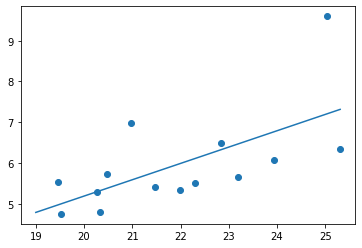

In [ ]:
Y=df_income["2010"].values.reshape(-1,1)
X=df_income["Haushaltseinkommen pro Kopf(in EUR)"].values.reshape(-1,1)
mean_X=np.mean(X)
mean_Y=np.mean(Y)
reg=LinearRegression().fit(X,Y)
m=reg.coef_[0]
c=mean_Y-m*mean_X
x=np.linspace(19,np.max(X),100)
plt.scatter(X,Y)

def func(x):
    return m*x+c
plt.plot(x,func(x))

__t_SNE relative und absolute Unterschiede zwischen Ost-West ausrechnen__

In [ ]:
X=np.array(df_new["2010"].dropna().values).reshape(-1,1)

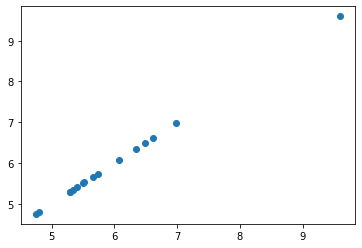

In [ ]:
plt.scatter(df_grouped["2010"],df_grouped["2010"])

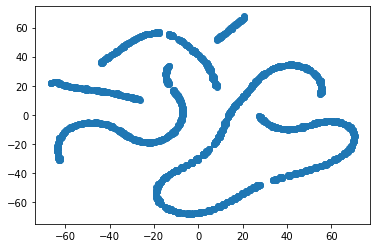

In [ ]:
from sklearn.manifold import TSNE
eastern_lst = ["Brandenburg",
                   "Mecklenburg-Vorpommern",
                   "Sachsen",
                   "Sachsen-Anhalt",
                   "Thueringen"]
tsne=TSNE(perplexity=25, n_iter=1000)
X_embedded = tsne.fit_transform(X)
plt.scatter(X_embedded[:,0], X_embedded[:,1])